Gain Extraction Model analyzes Patient Discharge Summaries and predicts the progress of a patient’s health. Gain Extraction Model can determine whether a patient has made any improvements in their health and if they have met their goals. This model offers an efficient and effective way to track a patient’s progress and ensure that they are receiving the best possible care.

## Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, evaluate, torch, accelerate, nltk, re, datetime 
import pandas as pd
from collections import Counter
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from datasets import load_metric
from transformers import TrainingArguments, Trainer
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
import seaborn as sns
from pynvml import *
from numba import cuda
import matplotlib.pyplot as plt

## Get Current Working Directory

In [2]:
my_dir = os.getcwd() + '/' 
print(f"CWD: {my_dir}")

CWD: /home/bilal/NLP/discharge_report_models/


## GPU Configuration

<p> Reset Cuda Memory</p>

In [3]:
device = cuda.get_current_device()
device.reset()
with torch.no_grad():
    torch.cuda.empty_cache()

<p>Check Memory</p>

In [4]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'Total    : {info.total//1024**2} MB')
print(f'Free     : {info.free//1024**2} MB')
print(f'Used     : {info.used//1024**2} MB')

Total    : 11176 MB
Free     : 11155 MB
Used     : 21 MB


### Get Cuda Device

In [5]:
devices = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
devices

device(type='cuda', index=0)

## Load Dataset

In [6]:
df = pd.read_csv('brog_train1_Updated.csv')
df.head()

,label,text
0,1,Patient has shown improvement with functional ...
1,0,DC from skilled PT services d/t patient reache...
2,0,Reconnect after 3 months.
3,0,This patient has been seen since 11/18/22 by s...
4,0,"During his POC, he had a transition of a prima..."


<p>Check Empty Rows</p>

In [7]:
print(f"Empty Label: {len(df[pd.isnull(df['label'])])}\nEmpty Sentence: {len(df[pd.isnull(df['text'])])}")

Empty Label: 0
Empty Sentence: 0


## Visualizing and Summarizing Label Distribution in DataFrame 'df'

label
0    1750
1     716
Name: count, dtype: int64


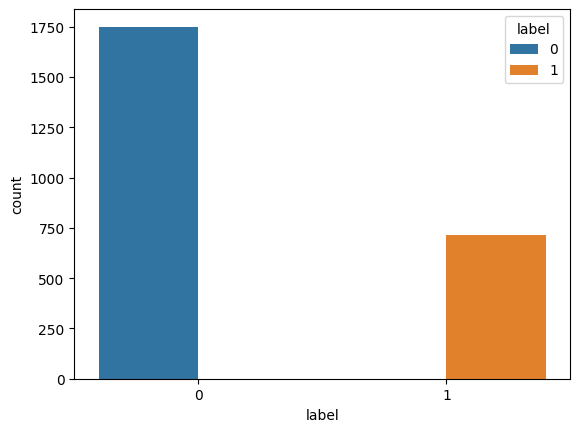

In [8]:
sns.countplot(x='label', data=df, hue='label')
print(df['label'].value_counts())

It's evident that we're facing a class imbalance issue here. To tackle this, we need to apply majority downsampling, which involves reducing the number of instances in the majority class to align with the number of instances in the minority class. In this scenario, it appears that the majority class comprises 1750 instances, whereas the minority class only has 716 instances.

## Cleansing Processes

All I did was do some cleansing processes, including removing some patterns, punctuations, English stop words  and rows with word count less then 3.

In [9]:
wordnet=WordNetLemmatizer()
corpus=[]
def preprossing(row):
    my_words1=[]
    my_words1 = re.sub('[^a-zA-Z]',' ', row)
    my_words1 = my_words1.lower().strip()
    my_words1 = my_words1.split()
    my_words1 = [wordnet.lemmatize(word) for word in my_words1 if not word in set(stopwords.words('english'))]
    my_words1 =  " ".join(my_words1)
    return my_words1

for i in range(len(df)):
    corpus.append(preprossing(df['text'][i]))

In [10]:
processed_df = pd.DataFrame({'sentence': corpus, 'label': df['label']})
processed_df.head()

,sentence,label
0,patient shown improvement functional transfer ...,1
1,dc skilled pt service patient reached maximum ...,0
2,reconnect month,0
3,patient seen since skilled pt,0
4,poc transition primary physical therapist may ...,0


### Majority Downsampling

To perform majority downsampling, we will remove rows with words count less than 8, as they contribute less to model performance.

In [11]:
df_filtered = processed_df[processed_df['label'] == 0]
df_filtered = df_filtered[df_filtered['sentence'].apply(lambda x: len(x.split()) <= 8)]
print(f"Number of rows with word length less then 3: {len(df_filtered)}")
df_filtered.head(10)

Number of rows with word length less then 3: 833


,sentence,label
2,reconnect month,0
3,patient seen since skilled pt,0
5,made slow progress throughout poc continues fa...,0
7,continues fall however fall preventative use u...,0
12,complained cramping time rle since change wate...,0
16,follow month,0
25,patient discharged today,0
27,pt report falling secondary impairment listed ...,0
34,patient met applicable goal therapy discharged...,0
36,pt also found mass lung biopsied result pending,0


### Remove rows with word count less then 8

In [12]:
indices_to_remove = df_filtered.index
processed_df = processed_df.drop(indices_to_remove)
processed_df = processed_df.reset_index(drop=True)
processed_df.head()

,sentence,label
0,patient shown improvement functional transfer ...,1
1,dc skilled pt service patient reached maximum ...,0
2,poc transition primary physical therapist may ...,0
3,however demonstrated mild improvement confiden...,1
4,majority fall occurred without using ustep due...,0


### Visualizing and Summarizing Label Distribution in DataFrame 'processed_df' after Majority Downsampling

label
0    917
1    716
Name: count, dtype: int64


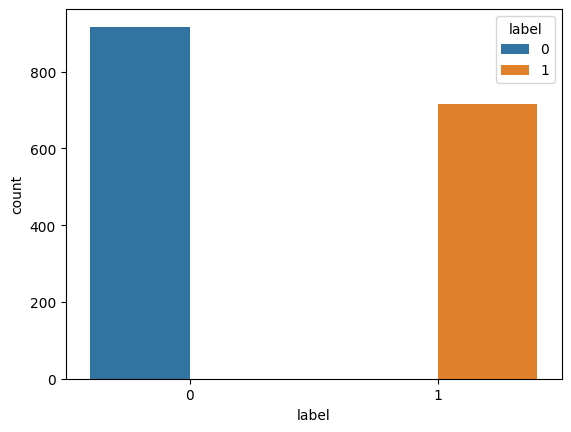

In [13]:
sns.countplot(x='label', data=processed_df, hue='label')
print(processed_df['label'].value_counts())

In [14]:
# processed_df.to_csv('processed_df.csv', index=False)

## Most Common Phrases

In [15]:
# Tokenize sentences and count occurrences for each class label
token_counts = {}
for label in [0, 1]:
    label_data = processed_df[processed_df['label'] == label]['sentence']
    all_tokens = [token for sent in label_data for token in word_tokenize(sent)]
    token_counts[label] = Counter(all_tokens)

# Extract 10 most common phrases for each class label
plot_data = []
for label, counts in token_counts.items():
    top_phrases = counts.most_common(10)
    for phrase, count in top_phrases:
        plot_data.append({'Phrase': phrase, 'Count': count})

plot_df_0 = pd.DataFrame(plot_data[:10])
plot_df_1 = pd.DataFrame(plot_data[10:])

### 10 most common phrases for 0 class label

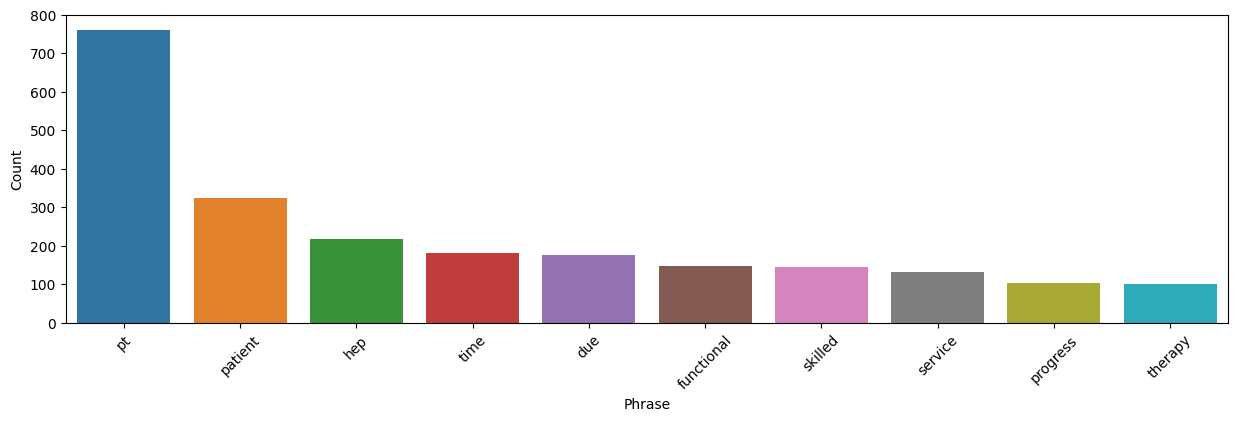

In [16]:
plt.figure(figsize=(15, 4))
ax = sns.barplot(data=plot_df_0, x="Phrase", y="Count")
ax.set(ylabel='Count')
plt.xticks(rotation=45)
plt.show()

### 10 most common phrases for 1 class label

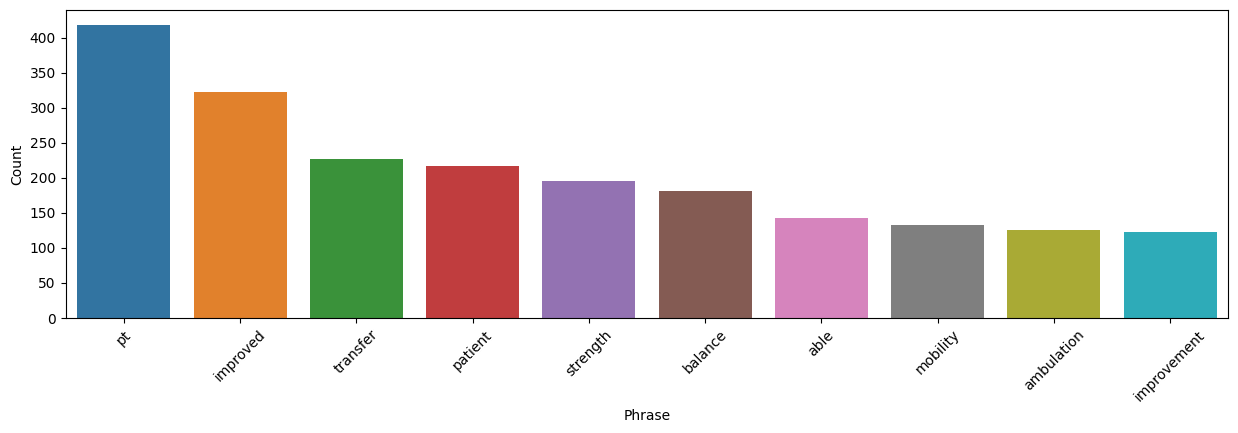

In [17]:
plt.figure(figsize=(15, 4))
ax = sns.barplot(data=plot_df_1, x="Phrase", y="Count")
ax.set(ylabel='Count')
plt.xticks(rotation=45)
plt.show()

## Load Pre-Processed Dataset

Split dataset to train, test and validation sets

In [56]:
# dataset = load_dataset('csv', data_files={'train': './processed_df.csv'}, split="train")
# dataset = load_dataset('csv', data_files={'train': './brog_train1.csv', 'test': './brog_test1.csv'})
data_dict = processed_df.to_dict(orient="list")
dataset = Dataset.from_dict(data_dict)
train_remaining_split = dataset.train_test_split(test_size=0.20)
test_validation_split = train_remaining_split['test'].train_test_split(test_size=0.50)

# Now you have train, validation, and test sets
train_set = train_remaining_split['train']
validation_set = test_validation_split['train']
test_set = test_validation_split['test']

dataset = DatasetDict({
    'train': train_set,
    'validate': validation_set,
    'test': test_set
    })


dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1306
    })
    validate: Dataset({
        features: ['sentence', 'label'],
        num_rows: 163
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 164
    })
})

<h2>Bio_ClinicalBERT</h2>

<p>The Bio_ClinicalBERT model was trained on all notes from MIMIC III, a database containing electronic health records from ICU patients at the Beth Israel Hospital in Boston, MA. For more details on MIMIC, see here. All notes from the NOTEEVENTS table were included (~880M words).</p>
<p>Each note in MIMIC was first split into sections using a rules-based section splitter (e.g. discharge summary notes were split into "History of Present Illness", "Family History", "Brief Hospital Course", etc. sections). Then each section was split into sentences using SciSpacy (en core sci md tokenizer).</p>

<a href="https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT"><p>For More Information Click Here</p> <a/>

## Load & Save Pre-Trained Tokenizer

If the tokenizer is not saved in the local directory, please uncomment the following cell code and execute it.

In [57]:
# tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
# tokenizer.save_pretrained(my_dir+"save_tokenizer_bcb")

### Load Pre-Trained Tokenizer locally

In [58]:
tokenizer = AutoTokenizer.from_pretrained('./save_tokenizer_bcb/')

## Load & Save Pre-Trained Model

If the model is not saved in the local directory, please uncomment the following cell code and execute it.

In [59]:
# pre_trained_model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)
# pre_trained_model.save_pretrained(my_dir+"save_model_bcb")

### Load Pre-Trained Model locally

In [60]:
pre_trained_model = AutoModelForSequenceClassification.from_pretrained("./save_model_bcb/", num_labels=2)

## Before Fine-Tuning Result (Bio_ClinicalBERT):

#### Check Max Length of sequences in dataset and Update max_length paraameter in tokenizer.

In [61]:
max_lengths = {}

# Iterate over each split
for split in dataset.keys():
    max_length = 0
    
    # Iterate over examples in the split
    for example in dataset[split]:
        # Tokenize the text
        tokenized_text = tokenizer(example['sentence'])
        
        # Get the length of the tokenized sequence
        sequence_length = len(tokenized_text['input_ids'])
        
        # Update max_length if necessary
        if sequence_length > max_length:
            max_length = sequence_length
    
    # Store the max length for the split
    max_lengths[split] = max_length

print("Maximum sequence lengths for each split:")
print(max_lengths)

Maximum sequence lengths for each split:
{'train': 112, 'validate': 60, 'test': 52}


### Use confusion matrix to evaluate the accuracy of pre-trained model result

In [62]:
print(f"Test Set Length: {len(dataset['test']['label'])}")
true_pos = len([i for i in dataset['test']['label'] if i == 1])
true_neg = len([i for i in dataset['test']['label'] if i == 0])
print(f"Actual/True +ve: {true_pos} \nActual/True -ve: {true_neg}")

Test Set Length: 164
Actual/True +ve: 70 
Actual/True -ve: 94


Confusion Matrix

<img src="https://miro.medium.com/v2/resize:fit:1218/1*jMs1RmSwnYgR9CsBw-z1dw.png" alt="Girl in a jacket" width="500" height="600">

Based on the maximum sequence we you have obtained for each split:

For the train split, the maximum sequence length is 112.
For the validate split, the maximum sequence length is 55.
For the test split, the maximum sequence length is 63.
You should choose a max_length that is larger than the maximum sequence length across all splits to ensure that no sequences get truncated during tokenization. A common approach is to choose a max_length that is slightly larger than the longest sequence in your dataset.

In this case, we could set the max_length to a value slightly higher than the maximum sequence length across all splits, such as 120 or 130, to provide some buffer room for longer sequences.

So, a suitable choice for max_length in your tokenizer could be 130. This ensures that all sequences in your dataset will be accommodated without truncation.

+ve Pred: 120 
-ve Pred: 44 


Accuracy: 0.4634146341463415


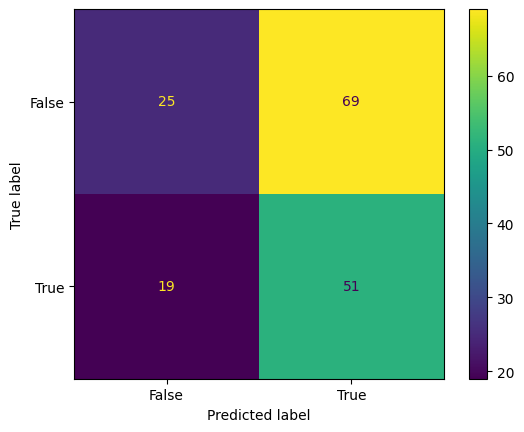

In [63]:
def tokenize_data(data):
    tokenized_data = tokenizer(data["sentence"], padding='max_length', max_length=130, truncation=True, return_tensors="pt")
    return tokenized_data

test_data = tokenize_data(dataset['test'])
# Define a function for evaluating the model
def evaluate_model(model, test_data):
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradients
    with torch.no_grad():
        # Move input tensors to the device
        input_ids = test_data['input_ids'].to(model.device)
        attention_mask = test_data['attention_mask'].to(model.device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Get predicted labels
        predicted_labels = np.argmax(logits.cpu().numpy(), axis=1)
    
    return predicted_labels

# Evaluate the model on test data
predicted_labels = evaluate_model(pre_trained_model, test_data)

# Total Positive and Negative Prediction made:
pos_pred = len([i for i in predicted_labels if i == 1])
neg_pred = len([i for i in predicted_labels if i == 0])
print(f"+ve Pred: {pos_pred} \n-ve Pred: {neg_pred} \n\n")

# Get true labels
true_labels = dataset['test']['label']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, list(predicted_labels))


# Compute accuracy
accuracy = accuracy_score(true_labels, list(predicted_labels))
print("Accuracy:", accuracy)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Here you can see that before fine-tuning, we achieved a 50% accuracy on the test dataset.

## Tokenization

Now create a function that will tokenize the text. You should also truncate longer sequences in the text to be no longer than the model’s maximum input length.

In [64]:
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', max_length=130, truncation=True)

Use Huggingface Datasets map function to apply the preprocessing function to the entire dataset. You can also set batched=True to apply the preprocessing function to multiple elements of the dataset at once for faster preprocessing:

In [65]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/1306 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1306
    })
    validate: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 163
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 164
    })
})

Now loads the accuracy evaluation metric, defines a function to compute metrics based on model predictions and true labels, and uses the loaded accuracy metric to compute the accuracy of the model's predictions.

In [66]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

1) Define training hyperparameters in TrainingArguments.
2) Pass the training arguments to Trainer along with the model, dataset and tokenizer.
3) Call train() to fine-tune your model.

In [67]:
training_args = TrainingArguments(
    output_dir="./fine_tuned_model_bcb/",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=1000,
    evaluation_strategy="steps",
    save_steps=500,
    eval_steps=5,
    logging_steps=5,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    push_to_hub=False,
)

In [69]:
trainer = Trainer(
    model=pre_trained_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validate'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Before training, navigate to the directory where checkpoints will be saved, which in my case is <b>/fine_tuned_model_bcb</b>, and execute the following command: <b>tensorboard --logdir=runs</b>. 
This command will serve TensorBoard on localhost at http://localhost:6006/.

## Start Training

To fine-tune the model on our dataset, we just have to call the train() method of our Trainer:

In [70]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
5,0.744200,0.693007,0.490798
10,0.697900,0.692967,0.490798
15,0.711000,0.692786,0.490798
20,0.755800,0.692275,0.496933
25,0.718900,0.691386,0.503067
30,0.697300,0.690529,0.515337
35,0.640400,0.690097,0.503067
40,0.677500,0.689422,0.503067
45,0.725700,0.688619,0.496933
50,0.735800,0.687395,0.509202


TrainOutput(global_step=1000, training_loss=0.4120384232858196, metrics={'train_runtime': 297.1089, 'train_samples_per_second': 13.463, 'train_steps_per_second': 3.366, 'total_flos': 266821332351600.0, 'train_loss': 0.4120384232858196, 'epoch': 3.06})

Save the fine-tuned model

In [ ]:
# trainer.save_model()

In [71]:
predictions = trainer.predict(tokenized_datasets['test'])
predictions = list(np.argmax(predictions.predictions, axis=-1))

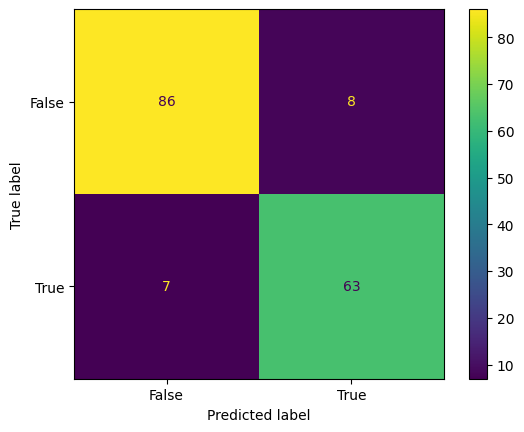

In [72]:
# Get true labels
true_labels = dataset['test']['label']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [73]:
accuracy = accuracy_score(true_labels, predictions)
accuracy

0.9085365853658537

Here you can see that after fine-tuning, we achieved a 95% accuracy on the test dataset.